# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle 

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("./Collision_Dataset_Imputed_06042022.csv")

# Overview
We would like to predict injury severity of the 2021 vehicular accident data. This is a classification problem in which effectiveness will ultimately be measured based on accuracy. 

Our plan of action:
1. Finalize features, one hot encode as necessary
2. Conduct feature selection
3. Using an 80/20 train/test split, perform four gridsearches on scaled features: logistic regression on all the features (base model), logistic regression on subset features, non-linear SVC (subset features), and linear SGDClassifier (subset features)
4. Elucidate the best performing models with highest accuracy and ascertain its accuracy on the hold out test set
5. Interpret the feature importance from logistic regression
6. Interpret support vectors
7. Discuss the advantages of each model as it relates to classification
8. Conclude with our findings

## Functions and Prepare Data for Model Building

#### Plot Functions

In [3]:
# Helper function to plot_feature_counts_by_grouping_level
def _set_patch_colors(ax, text_to_color_map):
    
    x_text_objects = ax.get_xticklabels()
    x_tick_positions = ax.get_xticks()
    
    text_to_coordinate_map = {x_text_obj.get_text():x_pos for x_text_obj, x_pos in zip(x_text_objects, x_tick_positions)}
    
    # Iterate across the x-tick text labels
    for text, text_x_pos in text_to_coordinate_map.items():
        
        # Grab the color associated with this text label
        color = text_to_color_map[text]
        
        # Iterate over the patches object, find the one at the location
        # that needs to be color next, then color it.
        for p in ax.patches:
            patch_x_pos = p.get_x()
            patch_width = p.get_width()
            patch_text_location = patch_x_pos + (patch_width/2)
            
            # If this is the location that needs to be colored next
            if patch_text_location == text_x_pos:
                p.set_color(c=color)
    
    return 

# Helper function to plot_feature_counts_by_grouping_level
def _get_text_to_color_map(ax, all_plot_column_levels, palette="husl"):
    
    # X-axis text objections
    x_text_objects = ax.get_xticklabels()
    
    # Color palette with one color for each level in the feature being plotted
    color_palette = sns.color_palette(palette=palette, n_colors=len(all_plot_column_levels))
    
    # Map axis label text --> color
    text_to_color_map = {x_text_obj.get_text():color for x_text_obj, color in zip(x_text_objects, color_palette[:len(x_text_objects)])}

    # Handling the one-off situation where the color map is going to be too short
    if len(text_to_color_map) < len(all_plot_column_levels):
        missing_levels = [column_name for column_name in all_plot_column_levels if column_name not in text_to_color_map]
        for index, level in enumerate(missing_levels):
            text_to_color_map[level] = color_palette[index]
    
    return text_to_color_map

# Helper function to plot_feature_counts_by_grouping_level
def _add_count_plot_annotations(ax, annot_vshift, round_digits, annot_fontsize, annotation_values=None):

    # Annotate the percentages on top of the bars
    for index, p in enumerate(ax.patches): 
            
        if annotation_values is not None:
            annot_value = annotation_values[index]
        else:
            # Percentage is the ratio of the bar height over the total people
            annot_value = f"{round((100 * (p.get_height() / num_observations)), round_digits)}%"

        # Annotate on the left edge of the bar
        x = p.get_x()
        
        # Annotate just above the top of the bar
        y = p.get_y() + p.get_height() + annot_vshift
        
        #Perform annotation
        ax.annotate(annot_value, (x,y), fontsize=annot_fontsize, fontweight='bold')
        
    return

def plot_predictions_by_class(dataframe, prediction_column=None, true_target_column="maxsev_imname",title_fontsize=16, xlab_fontsize=12, 
                              ylab_fontsize=12, tick_fontsize=12, tick_rotation=0, figsize=(25, 12), palette="husl", seaborn_style="white", 
                              nrows=2, ncols=2, normalize=False, title_weight="bold", xlab_weight="bold", 
                              ylab_weight="bold", tight_layout=True, add_annotations=True, annot_vshift=0.04, annot_fontsize=14,
                              round_digits=4, standard_anotation=True):
    
    sns.set_style(seaborn_style)
    
    # List of the levels in feature column
    target_levels = dataframe[true_target_column].unique().tolist()
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    
    for index, level in enumerate(target_levels):
        
        col = index % ncols
        row = index // ncols
        ax = axs[row][col]
        
        class_predictions_df = dataframe.loc[dataframe[true_target_column]==level, :]
        y_true = class_predictions_df.loc[:, true_target_column]
        y_pred = class_predictions_df.loc[:, prediction_column]
        
        prediction_dist = class_predictions_df.loc[:, prediction_column].value_counts(normalize=normalize)
        plot_df = pd.DataFrame({class_name:[num_predictions] for class_name, num_predictions in zip(prediction_dist.index.to_numpy(), 
                                                                                                    prediction_dist.to_numpy())})
        
        sns.barplot(data=plot_df, ax=ax)
        
        category_metrics = calculate_classification_metrics(y_true, y_pred)
        
        dataset_type = prediction_column.split("_")[0].capitalize()
        
        title = (f"Accuracy={category_metrics['accuracy']}\n"
                 f"Distribution of {dataset_type} Predictions when True Class = {level}")
        
        # Annotate plot axes
        ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
        ax.set_xlabel("Target Levels", fontsize=xlab_fontsize, weight=xlab_weight)
        ax.set_ylabel("Predictions", fontsize=ylab_fontsize, weight=ylab_weight)
        ax.tick_params(axis='both', labelsize=tick_fontsize, labelrotation=tick_rotation)
        
        # Text to color map lets us ensure that, across all plots, the bars with
        # the same x-label will also be the same color.
        if row == col == 0:
            text_to_color_map = _get_text_to_color_map(ax=ax, palette=palette, all_plot_column_levels=target_levels)
        
        # Ensure the bars with the same tick label have the same color, across all plots.
        _set_patch_colors(ax=ax, text_to_color_map=text_to_color_map)
        
        if add_annotations:
            _add_count_plot_annotations(ax=ax, 
                                        annot_vshift=annot_vshift, 
                                        round_digits=round_digits, 
                                        annot_fontsize=annot_fontsize, 
                                        annotation_values= sorted(prediction_dist.to_numpy(), reverse=True) if standard_anotation else None)
        
    
    if tight_layout:
        plt.tight_layout()
        
    return axs

def plot_confusion_matrix_by_target_class(dataframe, prediction_column=None, true_target_column="maxsev_imname", normalize=None,
                                          sample_weight=None, xticks_rotation="vertical", include_values=True, figsize=(8,8), 
                                          cmap="viridis", title=None, title_fontsize=12, title_weight="bold"):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, squeeze=True)
    
    y_true=dataframe.loc[:, true_target_column].to_numpy()
    
    labels=dataframe.loc[:, true_target_column].unique()
    
    y_pred=dataframe.loc[:,prediction_column].to_numpy()
    
    # Top row: TN, FN
    # Bottom row: FP, TP
    #all_confusion_matricies= multilabel_confusion_matrix(y_true=y_true, 
    #                                                     y_pred=y_pred, 
    #                                                     labels=labels)
    
    ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
    
    return ConfusionMatrixDisplay.from_predictions(y_true=y_true, 
                                                   y_pred=y_pred, 
                                                   labels=labels, 
                                                   include_values=include_values,
                                                   xticks_rotation=xticks_rotation,
                                                   normalize='pred',
                                                   cmap=cmap,
                                                   ax=ax)

#### Modeling Functions

In [4]:
def create_column_transformer(nominal_categorical_features, numeric_features, ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop"):
    
    preprocess = ColumnTransformer(transformers=[("ohe", OneHotEncoder(handle_unknown=ohe_handle_unknown), nominal_categorical_features), 
                                                 ("std_scaler", StandardScaler(), numeric_features)], 
                                   n_jobs=n_jobs, 
                                   remainder=remainder)
    
    return preprocess

def load_best_model_params(gridsearch_file, sort_metric="mean_test_accuracy", ascending=False):
    
    gs_results_df = pd.read_csv(gridsearch_file)
    
    gs_results_df = gs_results_df.sort_values(by=sort_metric, ascending=ascending)
    
    params = json.loads(gs_results_df.loc[gs_results_df.index==0, "params"].to_numpy()[0].replace("'", '"'))
    
    # Filter out model name
    params = {name.split("__")[-1]:value for name, value in params.items()}
    
    return params

def calculate_classification_metrics(y_true, y_pred, average="micro"):
    
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred) 
    recall = recall_score(y_true=y_true, y_pred=y_pred, average=average) 
    precision = precision_score(y_true=y_true, y_pred=y_pred, average=average) 
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average) 
    return {"accuracy":accuracy, "recall":recall, "precision":precision, "f1":f1}

def display_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test, average="micro"):
    
    train_metrics = calculate_classification_metrics(y_true=y_true_train, y_pred=y_pred_train, average=average)
    test_metrics = calculate_classification_metrics(y_true=y_true_test, y_pred=y_pred_test, average=average)
    
    print("================== Training Set Metrics ==================")
    print(f"Accuracy: {train_metrics['accuracy']}")
    print(f"Precision: {train_metrics['precision']}")
    print(f"Recall: {train_metrics['recall']}")
    print(f"F1: {train_metrics['f1']}")
    print("==========================================================\n")
    print("===================  Test Set Metrics = ==================")
    print(f"Accuracy: {test_metrics['accuracy']}")
    print(f"Precision: {test_metrics['precision']}")
    print(f"Recall: {test_metrics['recall']}")
    print(f"F1: {test_metrics['f1']}")
    print("==========================================================")

def train_and_evaluate_model(model, dataframe, target_column="maxsev_imname", test_size=0.2, 
                             random_state=42, display_clf_metrics=True, average="micro"):
    
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
    
    X_train = train_df.drop(columns=target_column)
    y_train = train_df[target_column].to_numpy()

    X_test = test_df.drop(columns=target_column)
    y_test = test_df[target_column].to_numpy()
    
    model.fit(X_train, y_train)
    
    train_predictions =  model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_df.loc[:, 'train_preds'] = train_predictions
    test_df.loc[:, 'test_preds'] = test_predictions
    
    if display_clf_metrics:
        display_metrics(y_true_train=y_train, 
                        y_pred_train=train_predictions, 
                        y_true_test=y_test, 
                        y_pred_test=test_predictions, 
                        average=average)
    
    return {'model':model,'train_df':train_df, 'test_df':test_df}

def create_sgd_svm_pipeline(nominal_categorical_features, numeric_features, gridsearch_file=None, ohe_handle_unknown='infrequent_if_exist', 
                            n_jobs=-1, remainder="drop", params=None, sort_metric="mean_test_accuracy", ascending=False, random_state=42, 
                            loss="hinge", max_iter=2_000, average=50, warm_start=True, n_iter_no_change=100, eta0=0.05):
    
    if gridsearch_file is not None:
        params = load_best_model_params(gridsearch_file=gridsearch_file, 
                                        sort_metric=sort_metric, 
                                        ascending=ascending)
        
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                           numeric_features=numeric_features, 
                                           ohe_handle_unknown=ohe_handle_unknown, 
                                           n_jobs=n_jobs, 
                                           remainder=remainder)
    
    sgd = SGDClassifier(loss=loss,
                        penalty=params.get("penalty","not_in_search") if params.get("penalty","not_in_search") != "not_in_search" else 'l2', 
                        alpha=params.get("alpha","not_in_search") if params.get("alpha","not_in_search") != "not_in_search" else 0.0001, 
                        fit_intercept=params.get("fit_intercept","not_in_search") if params.get("fit_intercept","not_in_search") != "not_in_search" else True,
                        l1_ratio=params.get("l1_ratio","not_in_search") if params.get("l1_ratio","not_in_search") != "not_in_search" else 0.15,    
                        learning_rate=params.get("learning_rate","not_in_search") if params.get("learning_rate","not_in_search") != "not_in_search" else "optimal", 
                        average=average, 
                        warm_start=warm_start,
                        max_iter=max_iter, 
                        eta0=eta0,
                        n_iter_no_change=n_iter_no_change,
                        n_jobs=n_jobs, 
                        random_state=random_state)
    
    sgd_pipeline = Pipeline(steps=[("preprocess", preprocess), 
                                   ("sgd", sgd)])
    
    return sgd_pipeline

def create_logisic_regression_pipeline(nominal_categorical_features, numeric_features, gridsearch_file=None, ohe_handle_unknown='infrequent_if_exist', 
                                       n_jobs=-1, remainder="drop", params=None, sort_metric="mean_test_accuracy", ascending=False, random_state=42, 
                                       break_ties=True, solver="saga", multi_class="multinomial", max_iter=400):
    
    if gridsearch_file is not None:
        params = load_best_model_params(gridsearch_file=gridsearch_file, 
                                        sort_metric=sort_metric, 
                                        ascending=ascending)
        
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                                   numeric_features=numeric_features, 
                                                   ohe_handle_unknown=ohe_handle_unknown, 
                                                   n_jobs=n_jobs, 
                                                   remainder=remainder)
    
    logreg = LogisticRegression(penalty=params.get("penalty","not_in_search") if params.get("penalty","not_in_search") != "not_in_search" else "l2",
                                C=params.get("C","not_in_search") if params.get("C","not_in_search") != "not_in_search" else 1, 
                                solver=solver, 
                                max_iter=max_iter,
                                multi_class=multi_class,
                                random_state=random_state)
    
    logreg_pipeline = Pipeline(steps=[("preprocess", preprocess), 
                                      ("logreg", logreg)])
    
    return logreg_pipeline

def create_svm_pipeline(nominal_categorical_features, numeric_features, gridsearch_file=None, ohe_handle_unknown='infrequent_if_exist', 
                        n_jobs=-1, remainder="drop", params=None, sort_metric="mean_test_accuracy", ascending=False, random_state=42, 
                        break_ties=True):
    
    if gridsearch_file is not None:
        params = load_best_model_params(gridsearch_file=gridsearch_file, 
                                        sort_metric=sort_metric, 
                                        ascending=ascending)
        
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                                   numeric_features=numeric_features, 
                                                   ohe_handle_unknown=ohe_handle_unknown, 
                                                   n_jobs=n_jobs, 
                                                   remainder=remainder)
    
    svm = SVC(C=params.get("C","not_in_search") if params.get("C","not_in_search") != "not_in_search" else 1,
              kernel=params.get("kernel","not_in_search") if params.get("kernel","not_in_search") != "not_in_search" else "rbf",
              degree=params.get("degree","not_in_search") if params.get("degree","not_in_search") != "not_in_search" else 3,
              gamma=params.get("gamma","not_in_search") if params.get("gamma","not_in_search") != "not_in_search" else "scale",
              break_ties=break_ties, 
              random_state=random_state)
    
    svm_pipeline = Pipeline(steps=[("preprocess", preprocess), 
                                   ("svm", svm)])
    
    return svm_pipeline

def gs_to_clean_df(search_results, task="classification", sort_metric=None, sort_ascending=True):
    
    gs_df = pd.DataFrame(search_results)
    
    start_column_names = gs_df.columns
    
    # Remove the columns that give statistics on time or specific cv fold splits
    filtered_column_names = [name for name in start_column_names if "time" not in name]
    filtered_column_names = [name for name in filtered_column_names if "split" not in name]
    
    # Remove columns not in the filtered list above
    columns_to_remove = [name for name in start_column_names if name not in filtered_column_names]
    gs_df.drop(columns=columns_to_remove, inplace=True)
    
    # Columns we want to keep. Remainder of the function just fixes up these columns.
    column_names = gs_df.columns
    modified_column_names = [name.split("__")[-1] for name in column_names]
    modified_column_names = [name.split("param_")[-1] for name in modified_column_names]
    
    # For any negative metrics, take the absolute value and remove negative from the name.
    for col_name in modified_column_names:
        if "_neg" in col_name:
            gs_df.loc[:, col_name] = gs_df.loc[:, col_name].abs()
    modified_column_names = [name.replace("_neg", "") for name in modified_column_names]
    
    # Shorten some names for easier readability
    if task == "regression":
        shortened_names = [("_root_mean_squared_error", "_RMSE"), ("_mean_squared_error", "_MSE"), ("_mean_absolute_error","_MAE")]
        for long_name, short_name in shortened_names:
            modified_column_names = [name.replace(long_name, short_name) for name in modified_column_names]
    
    
    # Perform the final renaming
    renaming_dict = {old_name:new_name for old_name, new_name in zip(column_names, modified_column_names)}
    gs_df.rename(columns=renaming_dict, inplace=True)

    if sort_metric is None:

        if task == "regression":
            gs_df.sort_values(by="mean_test_RMSE", inplace=True)
        else:
            gs_df.sort_values(by="mean_test_accuracy", ascending=False, inplace=True)

    else:
        gs_df.sort_values(by=sort_metric, ascending=sort_ascending, inplace=True)

    return(gs_df)

#### Feature Selection Functions

In [5]:
def get_random_forest_feature_importance(dataframe, nominal_categorical_features, numeric_features, target_column,
                                         ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop"):
    
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                           numeric_features=numeric_features, 
                                           ohe_handle_unknown=ohe_handle_unknown, 
                                           n_jobs=n_jobs, 
                                           remainder=remainder)
    
    rf_pipe = Pipeline(steps=[("preprocess", preprocess), 
                              ("rf", RandomForestClassifier(n_jobs=n_jobs))])
    
    all_features = nominal_categorical_features + numeric_features + [target_column]
    model_dataframe = dataframe.loc[:, all_features]
    
    X = model_dataframe.drop(columns=target_column)
    y = model_dataframe.loc[:, target_column]
    
    rf_pipe.fit(X, y)
    
    encoded_feature_names = rf_pipe.named_steps['preprocess'].get_feature_names_out()
    rf_feature_importances = rf_pipe.named_steps['rf'].feature_importances_
    
    rf_importances = [(name, score) for name, score in zip(encoded_feature_names, rf_feature_importances)]
    rf_importances_sorted = sorted(rf_importances, key = lambda sublist : sublist[1], reverse=True)
    
    return rf_importances_sorted

# Only for discrete features
def get_mutual_information_importances(dataframe, nominal_categorical_features, target_column,
                                       ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop"):
    
    discrete_features = nominal_categorical_features + [target_column]
    
    categorical_df = dataframe.loc[:, discrete_features]
    
    ohe = OneHotEncoder(handle_unknown="infrequent_if_exist")
    
    X = ohe.fit_transform(categorical_df.drop(columns=target_column))
    y = categorical_df[target_column]
    
    mutual_info = mutual_info_classif(X=X, y=y,discrete_features=True)
    
    mutual_info_scores = sorted([(name, score) for name, score in zip(ohe.get_feature_names_out(), mutual_info)], 
                                key = lambda sublist : sublist[1], reverse=True)
    
    return mutual_info_scores

def get_selectkbest_importances(dataframe, nominal_categorical_features, numeric_features, target_column,
                                ohe_handle_unknown='infrequent_if_exist', n_jobs=-1, remainder="drop", 
                                num_best_scores=20):
    
    preprocess = create_column_transformer(nominal_categorical_features=nominal_categorical_features, 
                                           numeric_features=numeric_features, 
                                           ohe_handle_unknown=ohe_handle_unknown, 
                                           n_jobs=n_jobs, 
                                           remainder=remainder)
    
    kbest_pipe = Pipeline(steps=[("preprocess", preprocess), 
                                 ("selector", SelectKBest(k=num_best_scores))])

    X = dataframe.drop(columns=target_column)
    y = dataframe[target_column]

    kbest_pipe.fit(X, y)
    
    selected_indicies = kbest_pipe.named_steps['selector'].get_support()
    top_scores = kbest_pipe.named_steps['selector'].scores_[selected_indicies]
    top_pvalues =  kbest_pipe.named_steps['selector'].pvalues_[selected_indicies]
    
    sorted_kbest_scores = sorted([(name, score) for name, score in zip(kbest_pipe.get_feature_names_out(), 
                                                                       top_scores)], key = lambda sublist : sublist[1], reverse=True)
    
    return sorted_kbest_scores

def plot_feature_importances(sorted_importances, title=None,  top_n=20, figsize=(18, 6), 
                             title_fontsize=12, title_weight="bold"):
    
    importances = sorted_importances[:top_n]
    
    importances_df = pd.DataFrame({name:score for name, score in importances}, index=[0])
    
    fix, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax = sns.barplot(data=importances_df, ax=ax,orient="h")
    
    ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
    ax.tick_params()
    
    return ax

#### Create dataframes for model building

In [6]:
target = "maxsev_imname"

numeric = ["age_im", "model_year_imputed", "trav_sp_imputed"]

nominal_categorical_long = ["body_type_binned", "speeding_status", "restraint_binned", "intersection_binned", "wkdy_imname",
                            "weather_cat2", "sex_imname", "alchl_imname", "lgtcon_imname", "hour_binned", "pcrash1_imname", 
                            'urbanicityname', 'vtrafwayname', 'vnum_lanname', 'vsurcondname', 'vtrafconname', 'reljct1name']

columns_to_keep_full = nominal_categorical_long + numeric + [target]

full_model_df = df.loc[:, columns_to_keep_full]

full_model_df.head(1)

,body_type_binned,speeding_status,restraint_binned,intersection_binned,wkdy_imname,weather_cat2,sex_imname,alchl_imname,lgtcon_imname,hour_binned,...,urbanicityname,vtrafwayname,vnum_lanname,vsurcondname,vtrafconname,reljct1name,age_im,model_year_imputed,trav_sp_imputed,maxsev_imname
0,1,unknown,Full,Yes,Wednesday,Not Clear,Female,No Alcohol Involved,Daylight,Morning,...,Rural,"Two-Way, Not Divided",Five lanes,Snow,Traffic control signal(on colors) not known wh...,No,61.0,2018,25.0,No Apparent Injury


In [7]:
nominal_categorical_short = ["body_type_binned", "speeding_status", "restraint_binned", "intersection_binned", "wkdy_imname",
                             "weather_cat2", "sex_imname", "alchl_imname", "lgtcon_imname", "hour_binned", "pcrash1_imname"]

columns_to_keep_short = nominal_categorical_short + numeric + [target]

model_df = df.loc[:, columns_to_keep_short]

model_df.head(1)

,body_type_binned,speeding_status,restraint_binned,intersection_binned,wkdy_imname,weather_cat2,sex_imname,alchl_imname,lgtcon_imname,hour_binned,pcrash1_imname,age_im,model_year_imputed,trav_sp_imputed,maxsev_imname
0,1,unknown,Full,Yes,Wednesday,Not Clear,Female,No Alcohol Involved,Daylight,Morning,Going Straight,61.0,2018,25.0,No Apparent Injury


## Finalize the features and other post-EDA work

Because we are dealing with multinomial classification, below is a visual to remind the reader of our response variable, injury severity. Their distribution is as follows: no apparent injury (44%), possible injury (41%), suspected injury (12%), and fatal injury (3%).

Some changes we made post-EDA:
- Removed `wrk_zonename` because over 98% of the observations were in category `none`
- Careful binning of `body_typname` (vehicle body type)
- Added `restraint_use`feature that indicated the driver's restraint use; binned into full, minimal, none, and unknown
- Added `pcrash1_imname` feature that designated driver's actions right before crash occurred e.g., going straight, turning left
- Imputed `trav_sp` (travel speed) and `mod_yearname` (vehicle year)
- Categorical features were one hot encoded prior to gridsearch

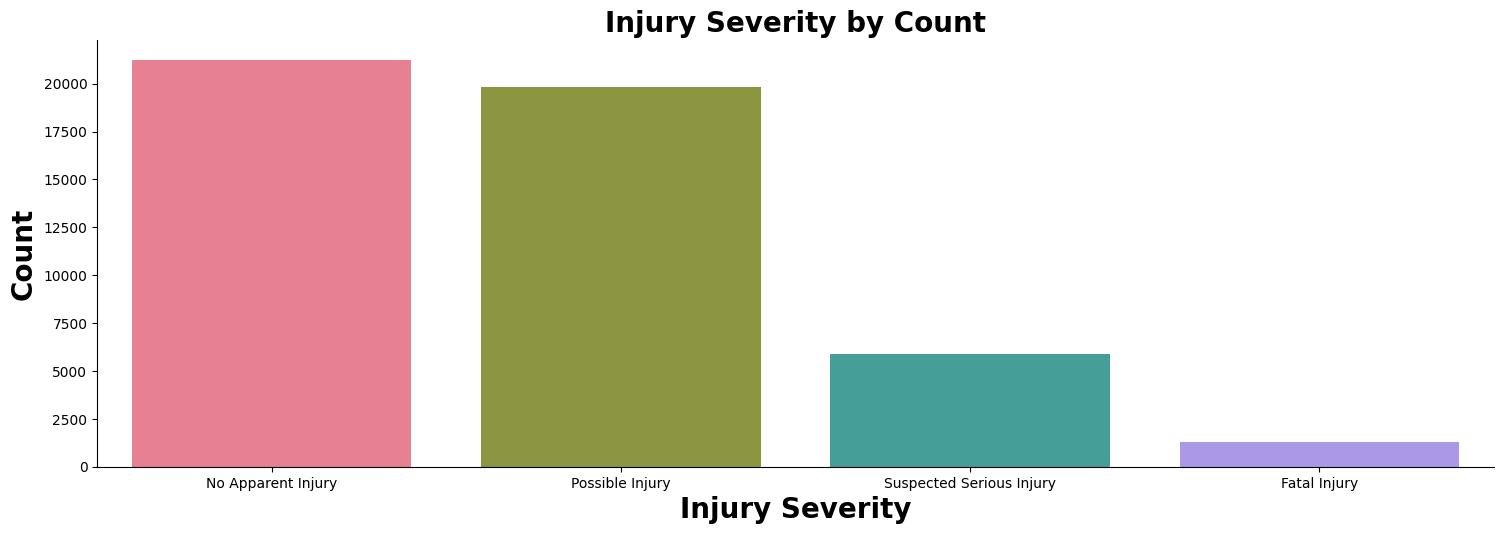

In [5]:
sns.catplot(data = df,
            x='maxsev_imname', 
            kind="count", 
            order=['No Apparent Injury','Possible Injury','Suspected Serious Injury', 'Fatal Injury'], 
            height=5, 
            aspect=3, 
            palette='husl');
plt.xlabel('Injury Severity', size=20, weight=1000)
plt.ylabel('Count', size=20, weight=1000)
plt.title("Injury Severity by Count", size=20, weight=1000);

## Feature Selection

This was conducted through three different feature importance methods: random forest, SelectKBest, and mutual information.

The three plots below depict the important features in descending order. We've highlighted the top 5 from each method.

**Random Forest:**
1. Travel speed
2. Age
3. Model year
4. Restraint use (full)
5. Body type (1)

**SelectKBest:**
1. Restraint use (full, none, other)
2. Travel speed
3. Body type (5)
4. Alcohol use (alcohol involved)
5. Hour (night time)

**Mutual Information:**
1. Restraint use (full, none, other)
2. Body type (5)
3. Alcohol use (involve, not involved)
4. Hour (night time)
5. Intersection (crash occured at a non-intersection part of the road)

In summary, the overlapping features were restraint use, body type, alcohol use, night time, and travel speed. This aligned with our intuition that injury severity is likely affected by the latter three features and driver's restraint use. Body type is an intriguing feature that we did not expect to see here. We will note the newly added `restraint_use` and careful consideration of `body_type_binned` made it into the top. Lastly, it is interesting to see random forest chose all continuous variables first.


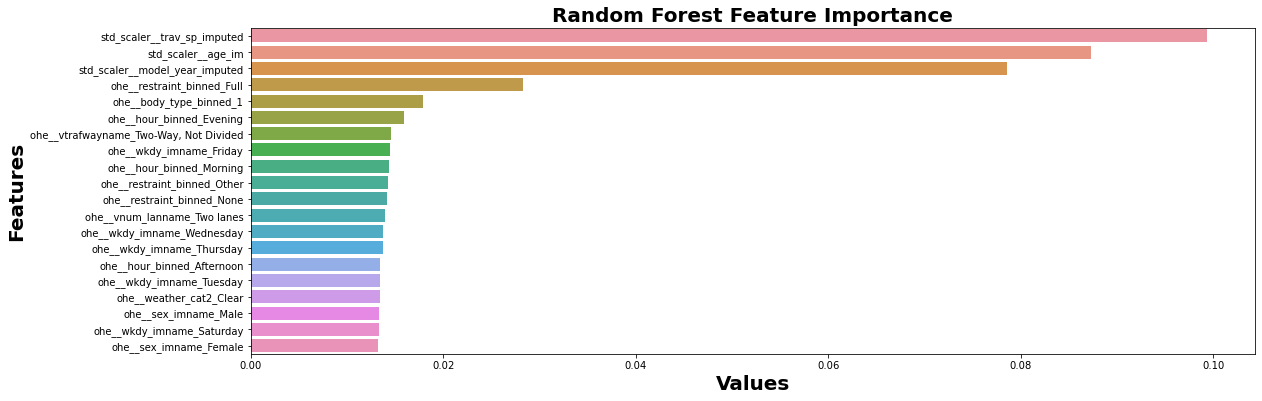

In [9]:
# Random Forest Feature Importance
rf_feature_importances = get_random_forest_feature_importance(dataframe=df, 
                                                              nominal_categorical_features=nominal_categorical_long, 
                                                                  numeric_features=numeric, 
                                                              target_column=target)

plot_feature_importances(sorted_importances=rf_feature_importances)
plt.xlabel('Values', size=20, weight=1000)
plt.ylabel('Features', size=20, weight=1000)
plt.title("Random Forest Feature Importance", size=20, weight=1000);

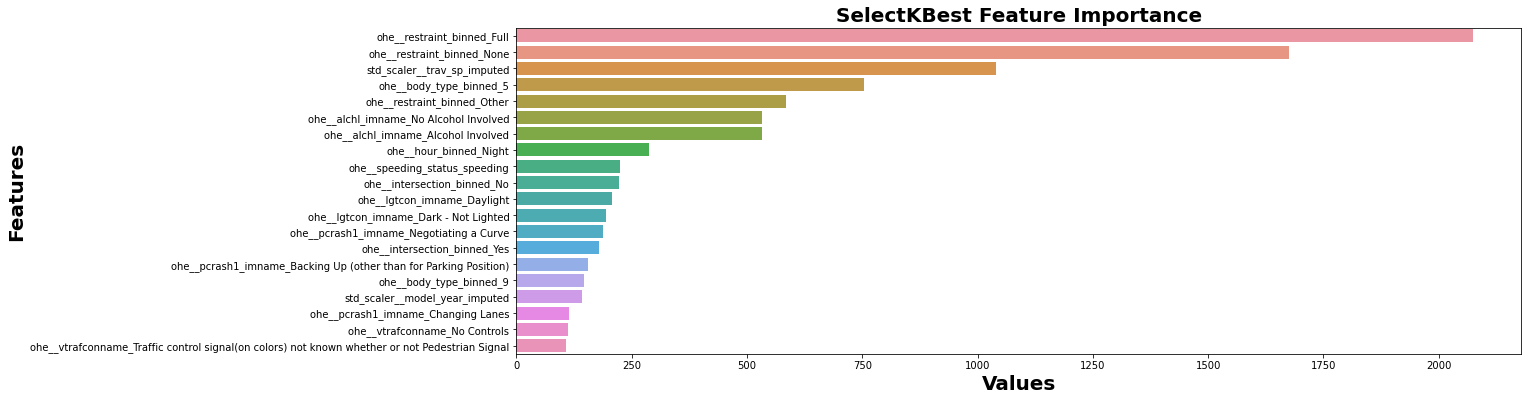

In [10]:
selectkbest_feature_importances = get_selectkbest_importances(dataframe=df, 
                            nominal_categorical_features=nominal_categorical_long, 
                            numeric_features=numeric, 
                            target_column=target,
                            num_best_scores=20)

plot_feature_importances(sorted_importances=selectkbest_feature_importances)
plt.xlabel('Values', size=20, weight=1000)
plt.ylabel('Features', size=20, weight=1000)
plt.title("SelectKBest Feature Importance", size=20, weight=1000);

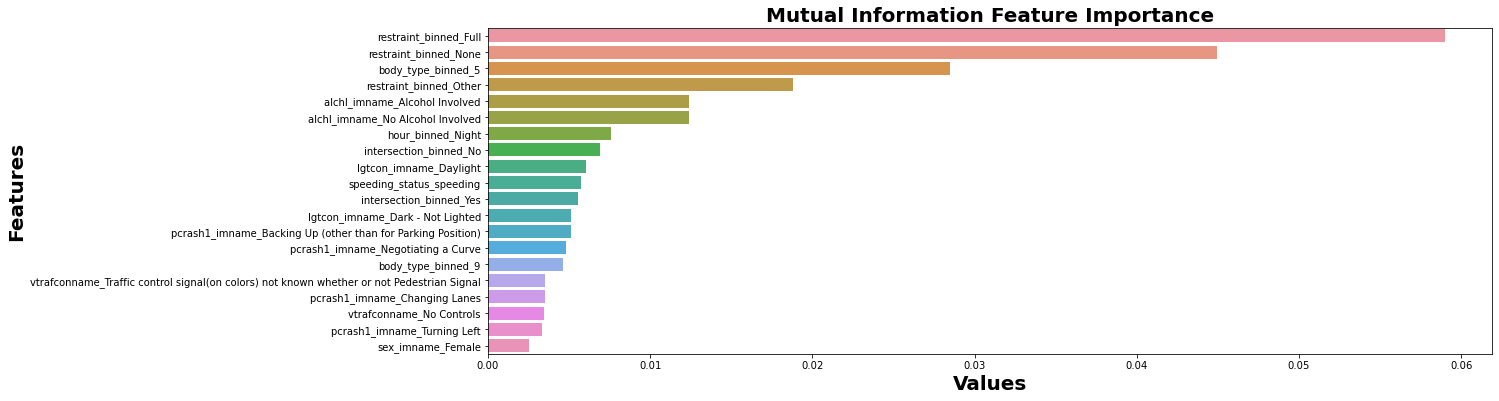

In [11]:
mutual_info_scores = get_mutual_information_importances(dataframe=df, 
                                                        nominal_categorical_features=nominal_categorical_long, 
                                                        target_column=target)

plot_feature_importances(sorted_importances=mutual_info_scores);
plt.xlabel('Values', size=20, weight=1000)
plt.ylabel('Features', size=20, weight=1000)
plt.title("Mutual Information Feature Importance", size=20, weight=1000);

# Create Models
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 50 points.

## Logistic Regression

A GridSearch was performed to select values for the following model hyperparameters:

- Penalty
- Regularization Strength (C)

Logistic regression was first conducted on all the features then subsequently on a subset based on feature selection. Below are the metrics on the 20% hold out test set. Since all the metrics were identical, we concluded with the parsimonious, reduced model that contained fewer features and a lower training time. 

In [12]:
chart = [
    ['Full', 0.56, 0.56, 0.56, 0.56],
    ['Reduced', 0.56, 0.56, 0.56, 0.56]
]
compare = pd.DataFrame(chart, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
compare

,Model,Accuracy,Precision,Recall,F1
0,Full,0.56,0.56,0.56,0.56
1,Reduced,0.56,0.56,0.56,0.56


### Logistic Regression: All Features (base model)

The plot below depicted the distribution of test set predictions for each class label indicated that this model had the most difficulty correctly classifying fatalities. A concerning result is that the most frequently predicted class for fatal collisions was "Possible Injury", a category that is two severity levels lower than the "Fatal Injury" label.

A positive aspect related to the two least severe categories (No Injury and Possible Injury) is that the most frequently generated predictions actually correspond to the true class label. Additional error analysis is needed to better understand why the most severe collisions are so difficult to identify. Finding new features that have better separation across the severity levels is one possible avenue for improving performance.

In [13]:
LOGREG_GRIDSEARCH_LARGE_PATH="./models/gs_logistic_regression_all_features_06042022.csv"
lr_full_gs_df = pd.read_csv(LOGREG_GRIDSEARCH_LARGE_PATH).sort_values(by="mean_test_accuracy", ascending=False)
lr_full_gs_df.head(1)


,C,penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
0,0.1,l2,"{'logreg__C': 0.1, 'logreg__penalty': 'l2'}",0.559894,0.00567,1,0.562802,0.001811,0.559894,0.00567,1,0.562802,0.001811,0.364792,0.008597,21,0.368857,0.00265


In [14]:
lr_full_pipe = create_logisic_regression_pipeline(nominal_categorical_features=nominal_categorical_long, 
                                                  numeric_features=numeric, 
                                                  gridsearch_file=LOGREG_GRIDSEARCH_LARGE_PATH)

lr_full_eval = train_and_evaluate_model(model=lr_full_pipe, 
                                        dataframe=full_model_df)

lr_full_train_df=lr_full_eval['train_df']
lr_full_test_df=lr_full_eval['test_df']

================== Training Set Metrics ==================
Accuracy: 0.5669111738938856
Precision: 0.5669111738938856
Recall: 0.5669111738938856
F1: 0.5669111738938856

===================  Test Set Metrics = ==================
Accuracy: 0.5582624922247563
Precision: 0.5582624922247563
Recall: 0.5582624922247563
F1: 0.5582624922247563


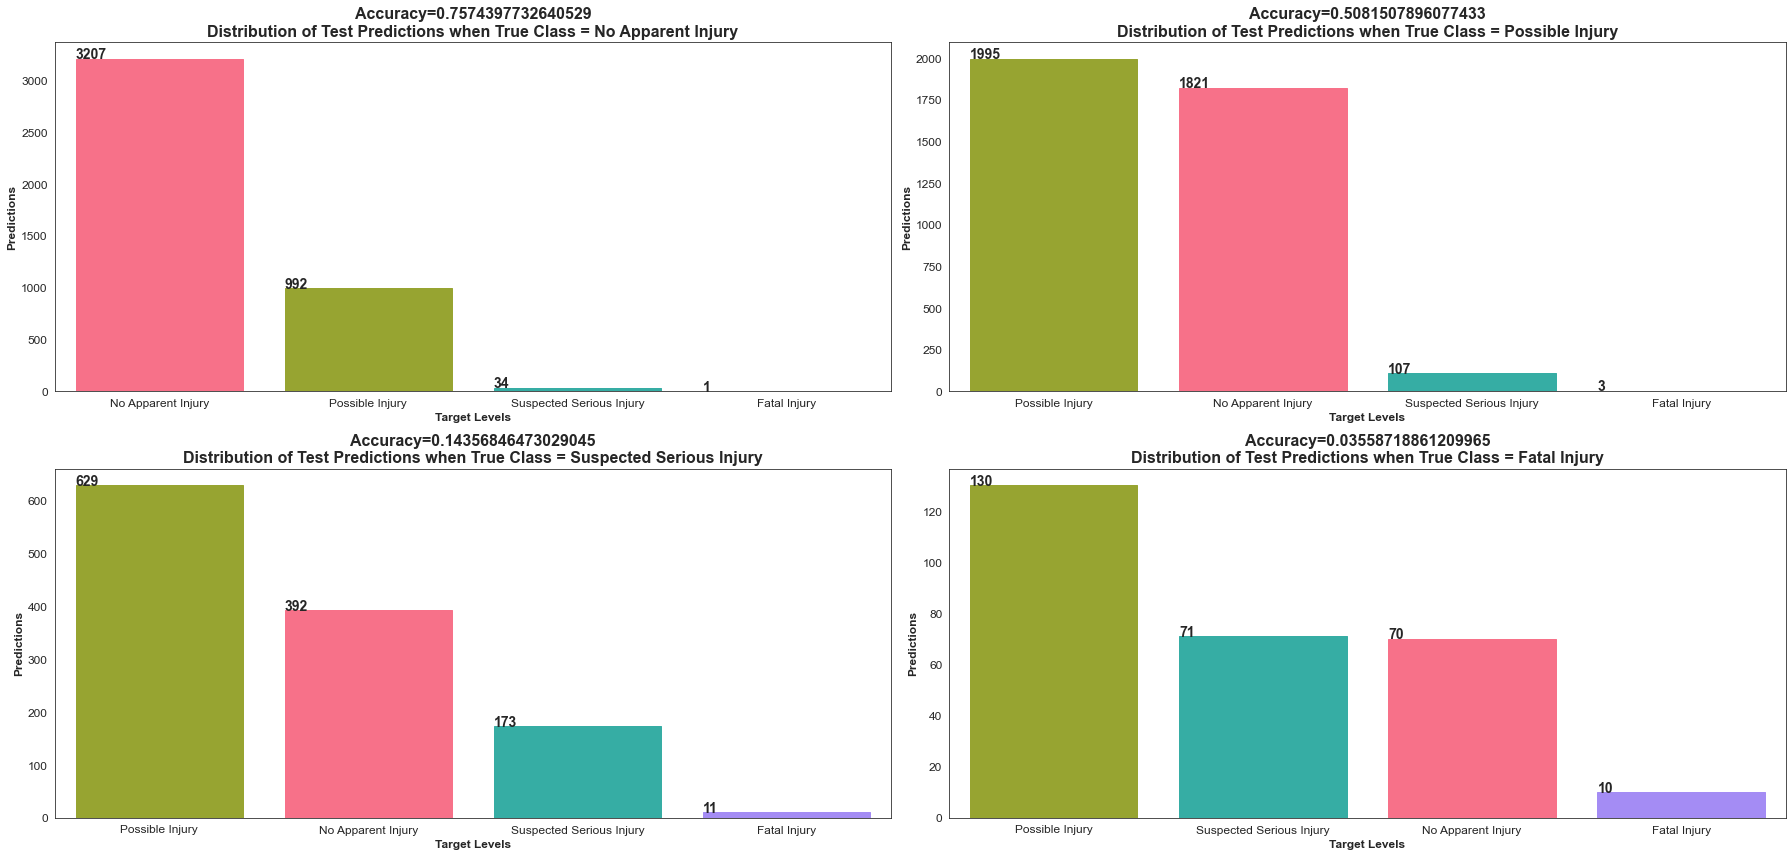

In [15]:
lr_full_count_axis = plot_predictions_by_class(dataframe=lr_full_test_df, 
                                               prediction_column="test_preds")

The barplots above show the counts of "When the true class is X, what was the predicted class?".

We have provided a color coded confusion matrix with the proportion of each column to give further insight into our model performance.

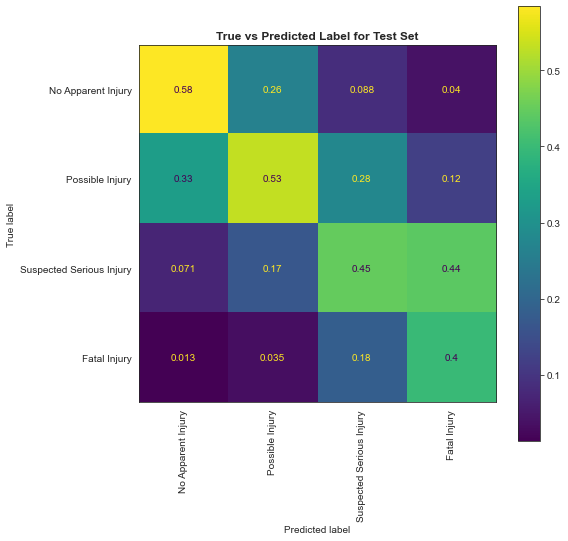

In [16]:
plot_confusion_matrix_by_target_class(dataframe=lr_full_test_df,
                                      prediction_column="test_preds", 
                                      title="True vs Predicted Label for Test Set");

### Logistic Regression: Reduced Features

This second logistic regression model was fit using only a subset of the features utilized by the model above. The following categorical features were removed:

`urbanicityname`, `vtrafwayname`, `vnum_lanname`, `vsurcondname`, `vtrafconname`, `reljct1name`

Since all categorical features were preprocessed through a OneHotEncoder, removing the six features above resulted in a significant decrease in the overall dimensionality of the features matrix. As shown below, this more parsimonious version of the model had very similiar performance, achieving a test set accuracy that is 2% lower than its larger counterpart. The subsequent models will utilize this reduced feature set.

As before, GridSearch was used to tune the following hyperparameters:

- Penalty
- Regularization Strength (C)

In [17]:
LOGREG_GRIDSEARCH_PATH="./models/gs_logistic_regression_06042022.csv"

lr_gs_df = pd.read_csv(LOGREG_GRIDSEARCH_PATH).sort_values(by="mean_test_accuracy", ascending=False)
lr_gs_df.head(1)

,C,penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
0,0.1,l2,"{'logreg__C': 0.1, 'logreg__penalty': 'l2'}",0.559894,0.00567,1,0.562802,0.001811,0.559894,0.00567,1,0.562802,0.001811,0.364792,0.008597,21,0.368857,0.00265


In [18]:
logreg_pipe = create_logisic_regression_pipeline(nominal_categorical_features=nominal_categorical_short, 
                                                 numeric_features=numeric, 
                                                 gridsearch_file=LOGREG_GRIDSEARCH_PATH)

logreg_eval = train_and_evaluate_model(model=logreg_pipe, 
                                       dataframe=model_df)

lr_train_result_df=logreg_eval['train_df']
lr_test_result_df=logreg_eval['test_df']

================== Training Set Metrics ==================
Accuracy: 0.5624271014229802
Precision: 0.5624271014229802
Recall: 0.5624271014229802
F1: 0.5624271014229802

===================  Test Set Metrics = ==================
Accuracy: 0.5559817540949616
Precision: 0.5559817540949616
Recall: 0.5559817540949616
F1: 0.5559817540949616


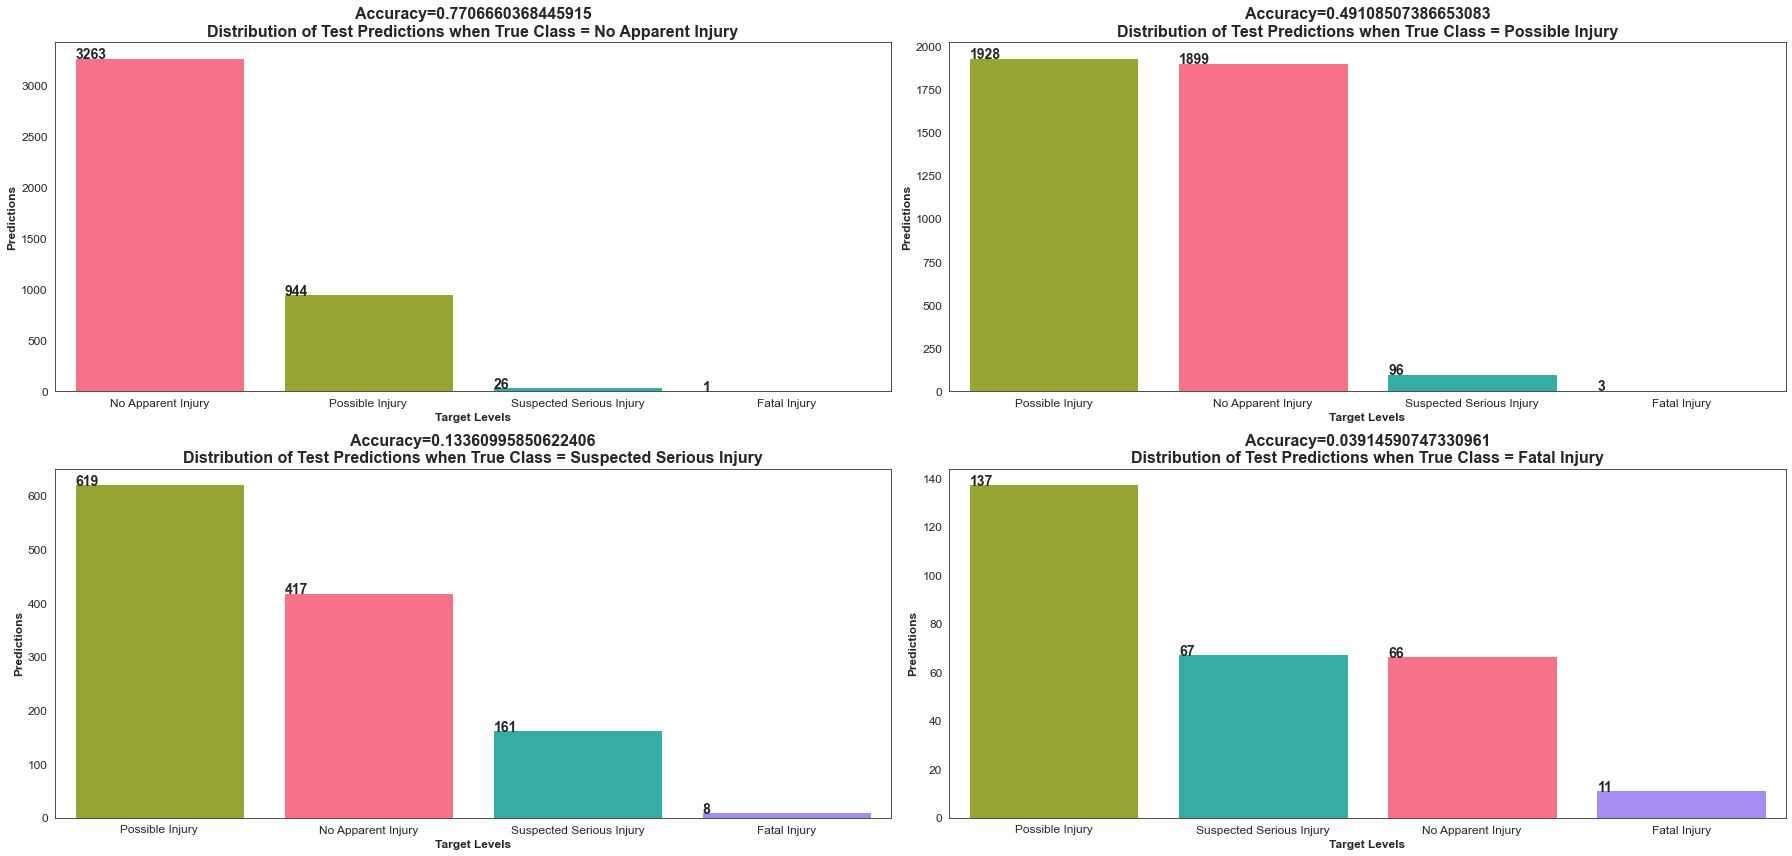

In [19]:
logreg_count_axis = plot_predictions_by_class(dataframe=lr_test_result_df, 
                                              prediction_column="test_preds")

The barplots above show the counts of "When the true class is X, what was the predicted class?".

We have provided a color coded confusion matrix with the proportion of each column to give further insight into our model performance.

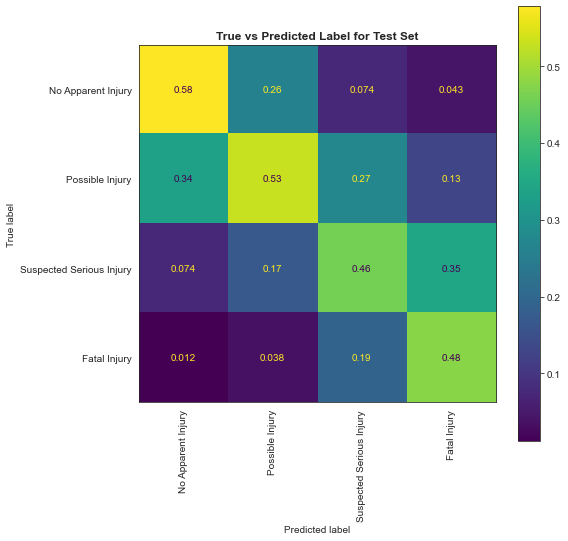

In [20]:
plot_confusion_matrix_by_target_class(dataframe=lr_test_result_df, 
                                      prediction_column="test_preds", 
                                      title="True vs Predicted Label for Test Set");

## Support Vector

The model shown below is a non-linear SVM, fit using Scikit-learns SVC() classifier with an rbf kernel. A GridSearch was utilized to tune the following hyperparameters:

- Strength of the L2 Regularization (C)
- Kernel coefficient (gamma)

Note that both the Non-linear SVM and linear SVM with SGDClassifier were fit using the same smaller subset of features used by the simple logistic regression model.

Below are the metrics on the 20% hold out test set.

In [21]:
chart = [
    ['Non-linear SVM', 0.58, 0.58, 0.58, 0.58],
    ['Linear SVM', 0.56, 0.56, 0.56, 0.56]
]
compare = pd.DataFrame(chart, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
compare

,Model,Accuracy,Precision,Recall,F1
0,Non-linear SVM,0.58,0.58,0.58,0.58
1,Linear SVM,0.56,0.56,0.56,0.56


### Non-Linear Support Vector Machine

As shown below, this significantly more complex model resulted in a very slight increase in the test set accuracy, at 2% higher than the simple logistic regression model above. A concerning result displayed in the both the prediction counts by class and confusion matricies below is that this model did not assign a single test observation to the fatality class, even when fatality was the true class label. One potential way to improve this undesired result could be to reference the svm_gs_df dataframe and refit the classifier using the hyperparameters that resulted in the largest F1 score rather than accuracy. This idea will be explored in future labs.

Since this model is both more expensive to fit and does not offer performance gains in the context of our accident severity classification problem, this model is not being considered a preferred option over the simple logistic regression model above.

The best non-linear SVM model utilizes the gamma="scale" kernel coefficient, and slightly less regularization (C=1.2) than the default C=1 and the default L2 penalty type.

In [22]:
SVM_GRIDSEARCH_PATH = "./models/gs_svm_06042022.csv"

svm_gs_df = pd.read_csv(SVM_GRIDSEARCH_PATH).sort_values(by="mean_test_accuracy", ascending=False)
svm_gs_df.head(1)

,C,gamma,kernel,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
0,1.2,scale,rbf,"{'svm__C': 1.2, 'svm__gamma': 'scale', 'svm__k...",0.571817,0.007374,1,0.605397,0.0012,0.571817,0.007374,1,0.605397,0.0012,0.350042,0.005775,4,0.387515,0.001634


In [23]:
svm_pipe = create_svm_pipeline(nominal_categorical_features=nominal_categorical_short, 
                               numeric_features=numeric,
                               gridsearch_file=SVM_GRIDSEARCH_PATH)

svm_eval = train_and_evaluate_model(model=svm_pipe, 
                                    dataframe=model_df)

svm_train_result_df = svm_eval['train_df']
svm_test_result_df = svm_eval['test_df']

================== Training Set Metrics ==================
Accuracy: 0.6060496099116145
Precision: 0.6060496099116145
Recall: 0.6060496099116145
F1: 0.6060496099116145

===================  Test Set Metrics = ==================
Accuracy: 0.5763010574331329
Precision: 0.5763010574331329
Recall: 0.5763010574331329
F1: 0.5763010574331329


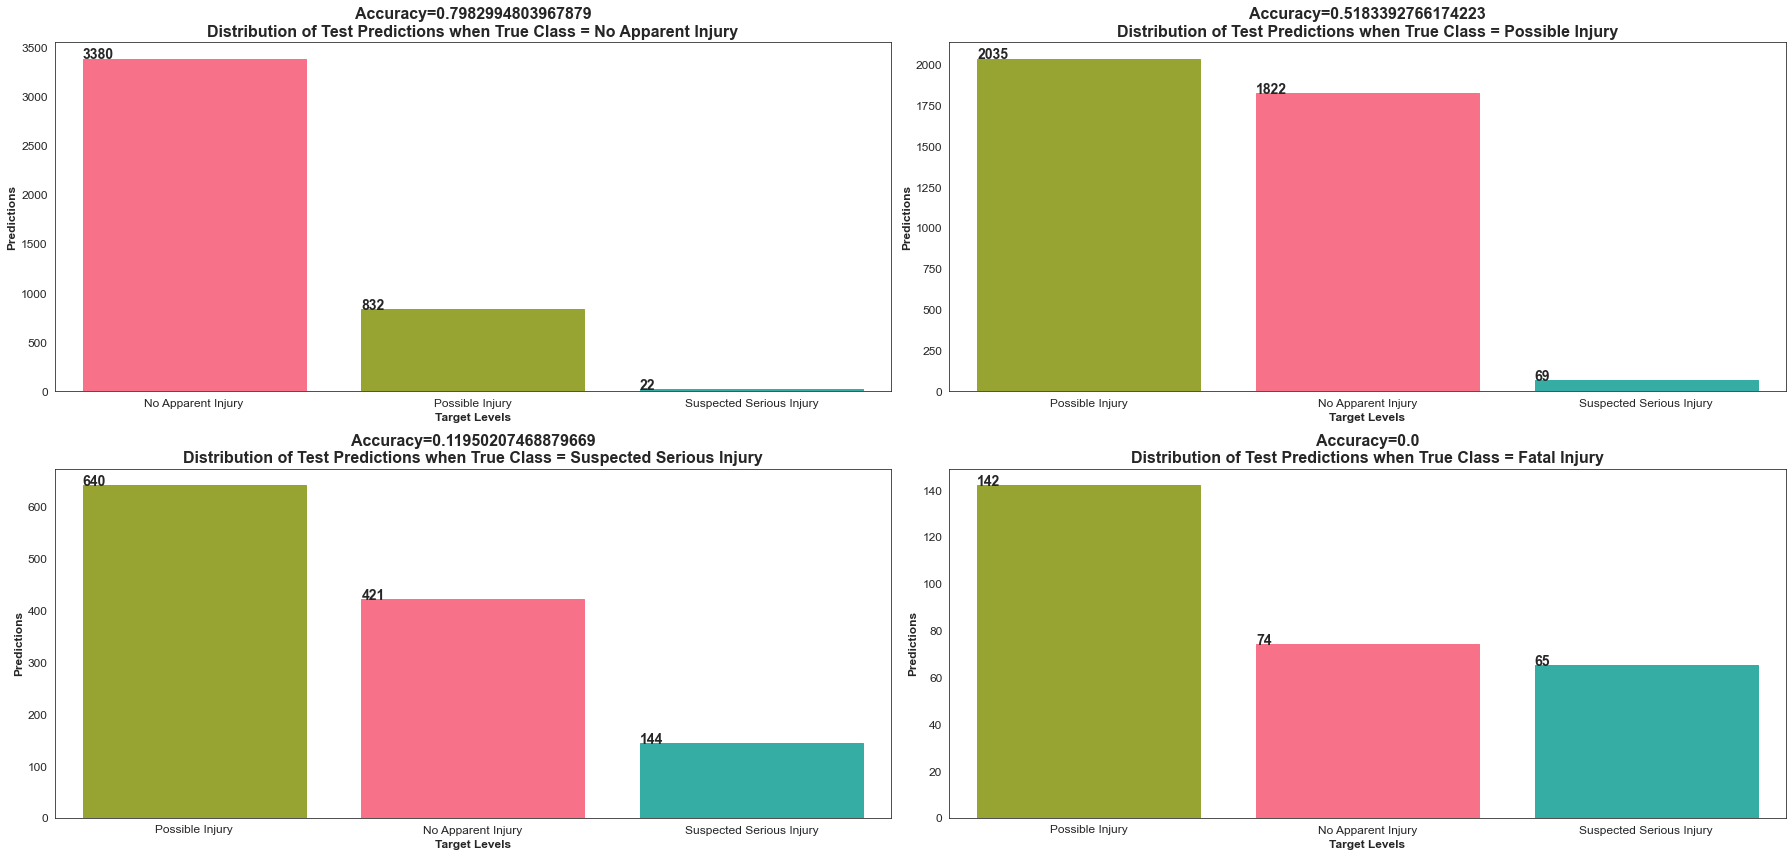

In [24]:
svm_count_axis = plot_predictions_by_class(dataframe=svm_test_result_df, prediction_column="test_preds")

The barplots above show the counts of "When the true class is X, what was the predicted class?".

We have provided a color coded confusion matrix with the proportion of each column to give further insight into our model performance.

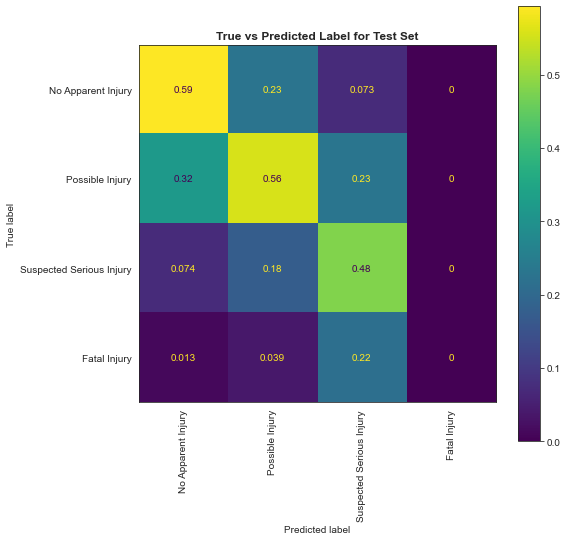

In [25]:
plot_confusion_matrix_by_target_class(dataframe=svm_test_result_df, 
                                      prediction_column="test_preds", 
                                      title="True vs Predicted Label for Test Set");

### Linear SVM - SGDClassifier

The model shown below is a linear support vector machine fit using gradient descent (SGDClassifier with hinge loss). Once again the final model arrived at via GridSearch, which tuned the following hyperparameter choices:

- Type of Regularization term (penalty)
- Regularization strength (alpha)
- Learning rate schedule (learning_rate)
- Initial learning rate (et0, only explored when schedule="adaptive")
- l1_ratio (mixing parameter for L1 and L2 regularizes, only used when penalty="elasticnet")

As shown in the results dataframe below, the best mean crossvalidation accuracy achieved by any linear support vector machine was nearly identical to the best model in the simple logistic regression gridsearch (~55.8%). The distribution of the test set predictions made by this model show that the linear support vector machine shares the same large drawback observed with the non-linear SVC() model, where not a single test observation was assigned to the fatality class. Once again, there are several reasons why this model is not considered superior to the simple logistic regression in the context of our problem. These reasons include, increased time to fit and tune, lack of a performance gain, and lowered interpretability.

The SGDClassifier used a regularzation strength of alpha=5e-6 (smaller than the default), and default values for the penalty type (L2) and learning rate schedule (optimal).

In [26]:
preprocess = ColumnTransformer(transformers=[("ohe", OneHotEncoder(handle_unknown='infrequent_if_exist'), nominal_categorical_short), 
                                             ("std_scaler", StandardScaler(), numeric)], 
                                      n_jobs=5)

linear_svm_pipe = Pipeline(steps=[("preprocess", preprocess), 
                                  ("svm", SGDClassifier(loss="hinge", 
                                                        n_jobs=5, 
                                                        warm_start=True, 
                                                        random_state=42, 
                                                        average=50, 
                                                        early_stopping=True, 
                                                        max_iter=2_000, 
                                                        n_iter_no_change=100))])

X = model_df.drop(columns=target)
y = model_df[target].to_numpy()

param_grid = [{'svm__penalty':['l1', 'l2'], 
              'svm__eta0':[0.5, 0.1, 0.05, 0.01, 0.005],
              'svm__alpha':[0.000005, 0.00005, 0.0001, 0.0005, 0.005, 0.01], 
              'svm__learning_rate':['adaptive']}, 
              {'svm__penalty':['l1', 'l2'], 
              'svm__alpha':[0.000005, 0.00005, 0.0001, 0.0005, 0.005, 0.01], 
              'svm__learning_rate':['optimal']}, 
              {'svm__penalty':['elasticnet'], 
              'svm__l1_ratio':[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
              'svm__alpha':[0.000001, 0.000005, 0.00005, 0.0001, 0.0005, 0.005, 0.01], 
              'svm__learning_rate':['optimal']}]

# Commented out so search is never accidentally re-run.
# Results are loaded from the .pkl file.
#gs = GridSearchCV(estimator=linear_svm_pipe,
#                  param_grid=param_grid,
#                  scoring=["accuracy", "f1_micro", "f1_macro"],
#                  refit="accuracy",
#                  n_jobs=5, 
#                  cv=5,
#                  verbose=3, 
#                  error_score='raise',
#                  return_train_score=True)

#gs.fit(X,y)

#with open("./gs_all_linear_svm_sgd_06042022.pkl", 'wb') as file:
#    pickle.dump(gs, file)

with open("gs_all_linear_svm_sgd_06042022.pkl", 'rb') as file:
    gs_results = pickle.load(file)

In [27]:
linear_svm_gs_results = gs_results.cv_results_
linear_svm_gs_df = gs_to_clean_df(pd.DataFrame(linear_svm_gs_results), sort_metric="mean_test_accuracy", sort_ascending=False).reset_index(drop=True)
linear_svm_gs_df.head()

,alpha,eta0,learning_rate,penalty,l1_ratio,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,...,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,mean_train_f1_micro,std_train_f1_micro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,mean_train_f1_macro,std_train_f1_macro
0,0.000005,NaN,optimal,l2,NaN,"{'svm__alpha': 5e-06, 'svm__learning_rate': 'o...",0.558090,0.006932,1,0.560765,...,0.558090,0.006932,1,0.560765,0.001222,0.335827,0.007702,3,0.338372,0.001067
1,0.000001,NaN,optimal,elasticnet,0.01,"{'svm__alpha': 1e-06, 'svm__l1_ratio': 0.01, '...",0.553217,0.004480,2,0.557001,...,0.553217,0.004480,2,0.557001,0.002994,0.336112,0.005201,2,0.338269,0.004985
2,0.0001,0.5,adaptive,l2,NaN,"{'svm__alpha': 0.0001, 'svm__eta0': 0.5, 'svm_...",0.551538,0.007221,3,0.553067,...,0.551538,0.007221,3,0.553067,0.001842,0.331731,0.008298,5,0.332545,0.002497
3,0.000005,0.5,adaptive,l2,NaN,"{'svm__alpha': 5e-06, 'svm__eta0': 0.5, 'svm__...",0.551289,0.006884,4,0.552999,...,0.551289,0.006884,4,0.552999,0.001363,0.332257,0.008094,4,0.333845,0.003769
4,0.0005,0.5,adaptive,l2,NaN,"{'svm__alpha': 0.0005, 'svm__eta0': 0.5, 'svm_...",0.551268,0.007370,5,0.552403,...,0.551268,0.007370,5,0.552403,0.001966,0.328073,0.009411,8,0.328781,0.003555


In [28]:
linear_svm_gs_df.loc[linear_svm_gs_df.index==0, "params"].to_numpy()[0]

{'svm__alpha': 5e-06, 'svm__learning_rate': 'optimal', 'svm__penalty': 'l2'}

# Model Advantages
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail. 10 points.

**For report cohesion, this section will be discussed near the end along with our conclusion.**

# Interpret Feature Importance
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important? 30 points.


Our model is built using the One-vs-the-rest strategy in sklearn.  Since there are 4 possible responses, 4 internal models were built.  We have chosen to interpret the top coefficients in the model predicting “Fatal Injury”.

1)	With everything else held constant, a car with a full restraint system in a crash is associated with a 38% decrease in the odds(e^-.98) of a fatal injury occurring
2)	With everything else held constant, an increase in 1 standard deviation of a car’s travelling speed is associated with a 97% increase(e^.68) in the odds of a fatal injury occurring.
3)	With everything else held constant, a car without any restraint system in a crash is associated with a 78%(e^.58) increase in the odds of a fatal injury occurring.
4)	With everything else held constant, when no alcohol is involved with a driver in a crash, there is an associated 59% decrease(e^-.52) in the odds of a fatal injury occurring.


The top 4 contributing coefficients in our model make sense from an intuitive stand-point. 

 Both having a restraint system and not being under the influence are something that instantly stood out to us.  These are things we are taught during our driver's education classes that increase our safety.
 Using the previous thought process, a car without any restraint system would cause a driver to be unbound from their seat so seeing a decrease in the odds makes sense with our prior beliefs.
 Finally,from classic physics, we know that as velocity increase, the amount of energy increases at a squared rate. It makes intuitive sense then that a car travelling at a higher velocity will cause more harm to the occupants.

In [29]:
##The list of coefficients for reference (Sorted by in descending order of a coefficient's absolute value)
log_names=logreg_pipe.named_steps['preprocess'].get_feature_names_out()
log_coefs=logreg_pipe.named_steps['logreg'].coef_[0]

log_beta=pd.DataFrame({'names':log_names,'coefs':log_coefs,'absolute value':abs(log_coefs)})
print(log_beta.sort_values('absolute value',ascending=False).to_string())

                                                                             names     coefs  absolute value
15                                                      ohe__restraint_binned_Full -0.981587        0.981587
71                                                     std_scaler__trav_sp_imputed  0.681107        0.681107
17                                                      ohe__restraint_binned_None  0.576747        0.576747
38                                           ohe__alchl_imname_No Alcohol Involved -0.525284        0.525284
10                                                        ohe__body_type_binned_12 -0.487465        0.487465
68                                               ohe__pcrash1_imname_Turning Right -0.443978        0.443978
4                                                          ohe__body_type_binned_5 -0.370060        0.370060
8                                                          ohe__body_type_binned_9  0.349266        0.349266
16                 

# Interpret Support Vectors
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset. 10 points.



#### Distribution of Support Vectors by Target Class

- The two target classes that this model has the worst prediction performance on (Fatal Injury and Suspected Serious Injury) account for 3.14% and 14.2% of the support vectors, respectively, which exceeds their percent representation in the dataset.

- In the print out from the cell below, we see that there are 32558 total support vectors. The training set only consisted of 38581 total observations, which means ~84.3% of all the available observations became a support vector. "When every point is a support vector there is too much freedom to bend and fit the training data - no generalization" (Pg 28, Link Below, R. Berwick, MIT). Although we have not reached the extreme where every point is support vector, the large percentage of support vectors shown here may be interpreted as evidence that the SVM has been given too much flexibility to model every aspect of the training set (including noise that does not generalize to future data). In future experiments we will explore how increasing the regularization strength effects the number of support vectors generated.

https://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf

In [30]:
total_support_vectors = np.sum(svm_pipe.named_steps['svm'].n_support_)
print(f"Total Number of Support Vectors: {total_support_vectors}, Total Training Observations: {int(model_df.shape[0]*0.8)}")
for class_name, num_support_vectors in zip(svm_pipe.named_steps['svm'].classes_, svm_pipe.named_steps['svm'].n_support_):
    print(f"Number of Support Vectors for Target Class {class_name} = {num_support_vectors}, or {(num_support_vectors/total_support_vectors)*100}% of all support vectors.")

Total Number of Support Vectors: 32558, Total Training Observations: 38581
Number of Support Vectors for Target Class Fatal Injury = 1025, or 3.148227778119049% of all support vectors.
Number of Support Vectors for Target Class No Apparent Injury = 12844, or 39.44959764113275% of all support vectors.
Number of Support Vectors for Target Class Possible Injury = 14063, or 43.19368511579335% of all support vectors.
Number of Support Vectors for Target Class Suspected Serious Injury = 4626, or 14.208489464954848% of all support vectors.


In [31]:
df.loc[:, "maxsev_imname"].value_counts(normalize=True)

No Apparent Injury          0.439816
Possible Injury             0.411554
Suspected Serious Injury    0.121550
Fatal Injury                0.027080
Name: maxsev_imname, dtype: float64

#### Dataframe of Support Vectors

In [32]:
support_vectors_df = pd.DataFrame(svm_pipe.named_steps['svm'].support_vectors_.todense(), columns=svm_pipe.named_steps['preprocess'].get_feature_names_out())
support_vectors_df.head()

,ohe__body_type_binned_1,ohe__body_type_binned_2,ohe__body_type_binned_3,ohe__body_type_binned_4,ohe__body_type_binned_5,ohe__body_type_binned_6,ohe__body_type_binned_7,ohe__body_type_binned_8,ohe__body_type_binned_9,ohe__body_type_binned_10,...,ohe__pcrash1_imname_Other(specify:),ohe__pcrash1_imname_Passing or Overtaking Another Vehicle,ohe__pcrash1_imname_Starting in Road,ohe__pcrash1_imname_Stopped in Roadway,ohe__pcrash1_imname_Successful Avoidance Maneuver to a Previous Critical Event,ohe__pcrash1_imname_Turning Left,ohe__pcrash1_imname_Turning Right,std_scaler__age_im,std_scaler__model_year_imputed,std_scaler__trav_sp_imputed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.280490,1.329682,1.191380
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.006061,-1.413681,0.774674
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.543849,1.185294,1.473898
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.099426,-2.568781,0.918252
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816103,0.752132,0.584415


### Add indicator column to original training set, specifying if that observation became a support vector

In [33]:
# Generate the same train test split used when training the model (same random state)
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)

# Reset the train_df indicies, so that match up with support vector indicies
train_df.reset_index(drop=True, inplace=True)

# Grab the row indicies for which elements became support vectors
support_vector_indicies = svm_pipe.named_steps['svm'].support_

# Add an indicator column to the original training set, to indicate if that observation ultimately became a support vector.
train_df["is_support_vector"] = [True if index in support_vector_indicies else False for index in train_df.index]

In [34]:
train_df.head(3)

,body_type_binned,speeding_status,restraint_binned,intersection_binned,wkdy_imname,weather_cat2,sex_imname,alchl_imname,lgtcon_imname,hour_binned,pcrash1_imname,age_im,model_year_imputed,trav_sp_imputed,maxsev_imname,is_support_vector
0,3,unknown,Full,No,Wednesday,Rain,Male,No Alcohol Involved,Daylight,Afternoon,Going Straight,24.0,2018,36.13373,No Apparent Injury,False
1,2,not speeding,Full,Yes,Thursday,Not Clear,Male,No Alcohol Involved,Daylight,Evening,Going Straight,17.0,2007,6.00000,Possible Injury,True
2,1,unknown,Full,Yes,Wednesday,Rain,Male,No Alcohol Involved,Daylight,Evening,Decelerating in Road,18.0,1993,28.81160,No Apparent Injury,True


#### Plot Code For Analyzing Support Vectors

In [35]:
# Helper function to plot_feature_counts_by_grouping_level
def _get_text_to_color_map(ax, all_plot_column_levels, palette="husl"):
    
    # X-axis text objections
    x_text_objects = ax.get_xticklabels()
    
    # Color palette with one color for each level in the feature being plotted
    color_palette = sns.color_palette(palette=palette, n_colors=len(all_plot_column_levels))
    
    # Map axis label text --> color
    text_to_color_map = {x_text_obj.get_text():color for x_text_obj, color in zip(x_text_objects, color_palette[:len(x_text_objects)])}

    # Handling the one-off situation where the color map is going to be too short
    if len(text_to_color_map) < len(all_plot_column_levels):
        missing_levels = [column_name for column_name in all_plot_column_levels if column_name not in text_to_color_map]
        for index, level in enumerate(missing_levels):
            text_to_color_map[level] = color_palette[index]
    
    return text_to_color_map

# Helper function to plot_feature_counts_by_grouping_level
def _set_patch_colors(ax, text_to_color_map):
    
    x_text_objects = ax.get_xticklabels()
    x_tick_positions = ax.get_xticks()
    
    text_to_coordinate_map = {x_text_obj.get_text():x_pos for x_text_obj, x_pos in zip(x_text_objects, x_tick_positions)}
    
    # Iterate across the x-tick text labels
    for text, text_x_pos in text_to_coordinate_map.items():
        
        # Grab the color associated with this text label
        color = text_to_color_map[text]
        
        # Iterate over the patches object, find the one at the location
        # that needs to be color next, then color it.
        for p in ax.patches:
            patch_x_pos = p.get_x()
            patch_width = p.get_width()
            patch_text_location = patch_x_pos + (patch_width/2)
            
            # If this is the location that needs to be colored next
            if patch_text_location == text_x_pos:
                p.set_color(c=color)
    
    return 

# Helper function to plot_feature_counts_by_grouping_level
def _add_count_plot_annotations(ax, num_observations, annot_vshift, round_digits, annot_fontsize):

    # Annotate the percentages on top of the bars
    for p in ax.patches: 
            
        # Percentage is the ratio of the bar height over the total people
        percentage = f"{round((100 * (p.get_height() / num_observations)), round_digits)}%"

        # Annotate on the left edge of the bar
        x = p.get_x()
        
        # Annotate just above the top of the bar
        y = p.get_y() + p.get_height() + annot_vshift
            
        #Perform annotation
        ax.annotate(percentage, (x,y), fontsize=annot_fontsize, fontweight='bold')
        
    return

# Basic count plot for factors
def plot_sorted_level_counts(dataframe, plotting_column, title, xlabel, ylabel, ylab_fontsize=12, title_fontsize=16,
                             xlab_fontsize=12, tick_fontsize=12, tick_rotation=45, ax=None, figsize=(10, 7), annot_fontsize=14, 
                             round_digits=4, add_annotations=True, annot_vshift=0.04, palette="husl", seaborn_style="white", 
                             title_weight='bold', xlab_weight='bold', ylab_weight='bold'):

    sns.set_style(seaborn_style)
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    # Order to plot the bars in
    plot_order = dataframe[plotting_column].value_counts().sort_values().index.tolist()

    # Add the plot
    sns.countplot(data=dataframe, x=plotting_column, ax=ax, order=plot_order, palette=palette)
        
    # Annotate plot axes
    ax.set_title(f"{title}", fontsize=title_fontsize, weight=title_weight)
    ax.set_xlabel(xlabel, fontsize=xlab_fontsize, weight=xlab_weight)
    ax.set_ylabel(ylabel, fontsize=ylab_fontsize, weight=ylab_weight)
    ax.tick_params(axis='both', labelsize=tick_fontsize, labelrotation=tick_rotation)
    
    if add_annotations:
        _add_count_plot_annotations(ax=ax, 
                                    num_observations=dataframe.shape[0], 
                                    annot_vshift=annot_vshift, 
                                    round_digits=round_digits, 
                                    annot_fontsize=annot_fontsize)
    
    return 

### Plotting Functions
# Plot the distribution of categorical features, and the percentage of observations in each level.
def plot_feature_counts_by_grouping_level(dataframe, plotting_column, grouping_column, num_rows=1, num_cols=2,
                                          title_fontsize=16, xlab_fontsize=12, ylab_fontsize=12, tick_fontsize=12, tick_rotation=45,
                                          annot_fontsize=14, round_digits=4, add_annotations=True, figsize=(18, 7), annot_vshift=0.04,
                                          palette="husl", seaborn_style="white"):
    sns.set_style(seaborn_style)
    
    # List of the levels in feature column
    group_feature_levels = dataframe[grouping_column].unique().tolist()

    # List of the levels in the plotting column, used to handle one-off circumstances where text_to_color_map
    # Is missing colors for some factor levels because the plotting_column did not have any observations
    # of that type in the first group of grouping_column
    all_plot_column_levels = dataframe[plotting_column].unique().tolist()
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize, squeeze=False)
    
    # For each plot we are going to add
    for index, level in enumerate(group_feature_levels):
        
        plot_df = dataframe.loc[dataframe[grouping_column]==level, :]
        
        title = f"Distribution of {plotting_column}\nWhen {grouping_column}={level}\nTotal Number of Observations={plot_df.shape[0]}"
        xlabel = plotting_column
        ylabel = f"Count of {plotting_column}"
        
        # Grab the grid location for this plot
        col = index % num_cols
        row = index // num_cols
        
        plot_sorted_level_counts(dataframe=plot_df, 
                                 plotting_column=plotting_column, 
                                 ax=axs[row][col],
                                 title=title, 
                                 xlabel=xlabel, 
                                 ylabel=ylabel, 
                                 ylab_fontsize=ylab_fontsize, 
                                 title_fontsize=title_fontsize, 
                                 xlab_fontsize=xlab_fontsize,
                                 tick_fontsize=tick_fontsize, 
                                 tick_rotation=tick_rotation, 
                                 annot_fontsize=annot_fontsize, 
                                 round_digits=round_digits, 
                                 add_annotations=add_annotations, 
                                 annot_vshift=annot_vshift)
        
        # Text to color map lets us ensure that, across all plots, the bars with
        # the same x-label will also be the same color.
        if row == col == 0:
            text_to_color_map = _get_text_to_color_map(ax=axs[row][col], palette=palette, all_plot_column_levels=all_plot_column_levels)
        
        # Ensure the bars with the same tick label have the same color, across all plots.
        _set_patch_colors(ax=axs[row][col], text_to_color_map=text_to_color_map)
    

    return plt.tight_layout()

### Analyze Support Vectors:  Distribution of target classes, broken down by whether or not the observation became a support vector

A key takeaway in the plot below is that ALL of the observations in the "Fatality" target class became support vectors. Similarly, the vast majority of the "Suspected Serious Injury" class also became support vectors (less than 1% of the non-support vector observations belong to this class). This plot helps explain why the model was unable to predict a single fatal crash correctly on the test set. The SVM had completely overfit to the fatal crashes in the training data.

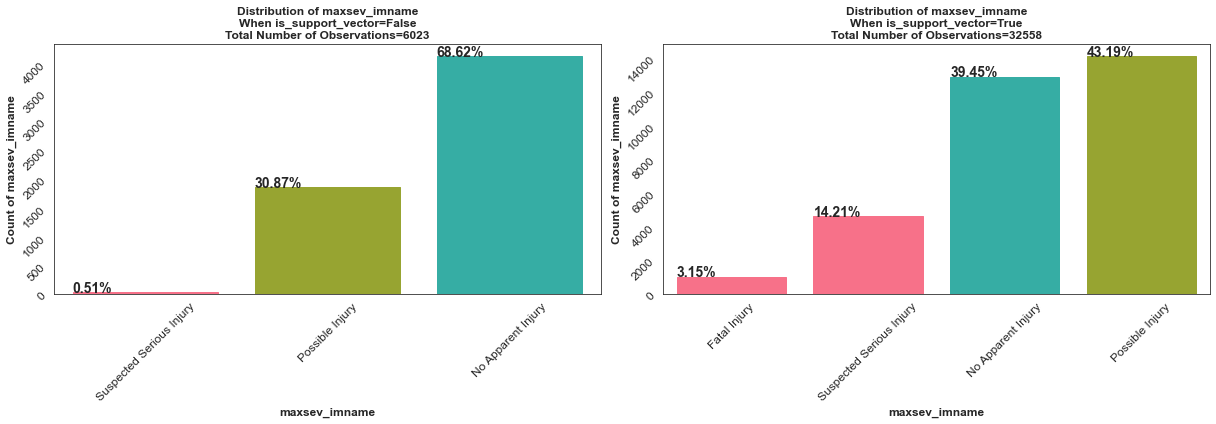

In [36]:
plot_feature_counts_by_grouping_level(dataframe=train_df, 
                                      plotting_column="maxsev_imname", 
                                      grouping_column="is_support_vector", 
                                      num_rows=1, 
                                      num_cols=2, 
                                      figsize=(17, 6), 
                                      title_fontsize=12,
                                      round_digits=2, 
                                      tick_rotation=45)

#### Speeding feature distribution by support vector status

In the cell below we show how the distribution of the speeding status feature changes based on whether or not the observation ultimately became a support vector. An interesting note is the increased percentage of drivers who were speeding in the set of observations which became support vectors (6.62%) vs those which did not (3.4%). For reference the overall distribution of this feature is provided two cells down. 

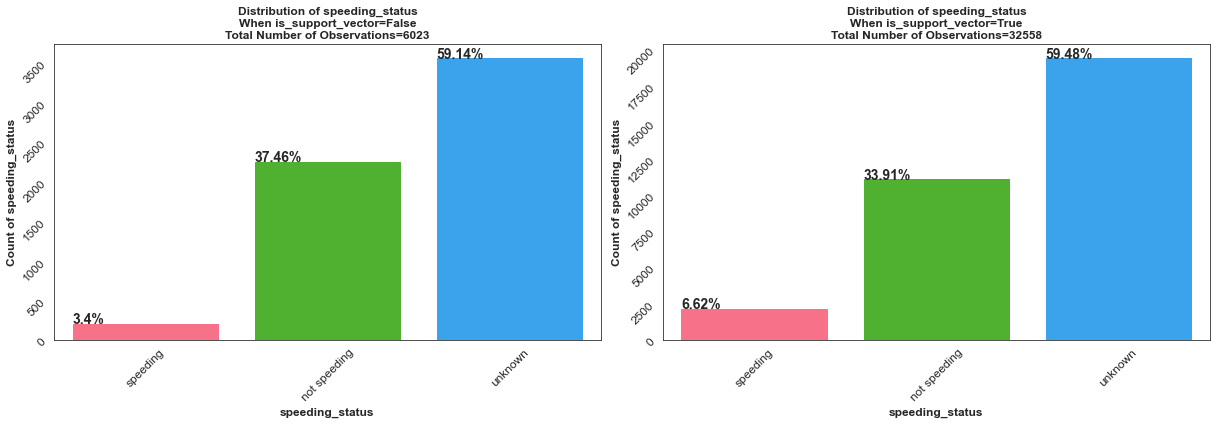

In [37]:
plot_feature_counts_by_grouping_level(dataframe=train_df, 
                                      plotting_column="speeding_status", 
                                      grouping_column="is_support_vector", 
                                      num_rows=1, 
                                      num_cols=2, 
                                      figsize=(17, 6), 
                                      title_fontsize=12,
                                      round_digits=2, 
                                      tick_rotation=45)

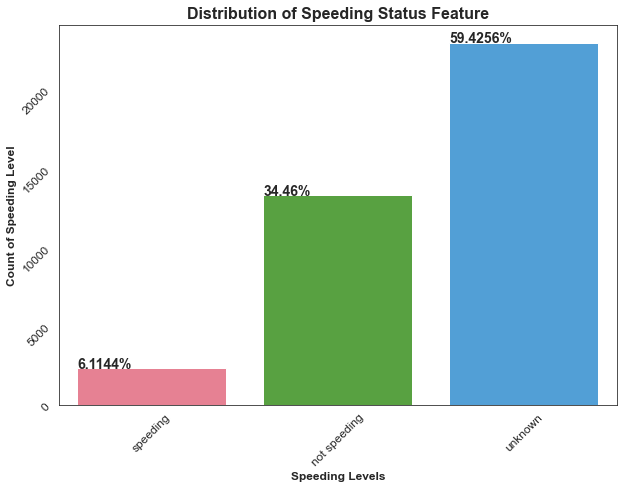

In [38]:
plot_sorted_level_counts(dataframe=train_df, 
                         plotting_column="speeding_status", 
                         xlabel="Speeding Levels",
                         ylabel="Count of Speeding Level",
                         title="Distribution of Speeding Status Feature")

# Model Advantages
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail. 10 points.

**Logistic regression**
- Capable of prediction and interpretation
- Faster training time
- Lower computational cost
- Simpler model, more likely to suffer from bias when trying to model complex signals
- Conducive to relatively small data sets with known variables

**SVM**
- More powerful algorithm to capture complex signal
- More complex, more likely to suffer from variance (overfitting)
- More likely to produce higher prediction accuracy due to efficient hyperplane separation
- Conducive to large / high dimensional data sets, structured and non-structured data type such as images and text

We theorized that logistic regression would perform worse due to the complexity of our QOI. SVC has higher approximation power and likely discern complex functions. This in turn should yield better prediction accuracy although we acknowledge there will be a hit on training time. In the context of our models, SVM showed signs of overfit.

# Conclusion

The metrics on the 20% hold out test set are printed below. Based on these results, it technically agreed with our theory that logistic regression would perform worse due to its less complex algorithm. We ultimately selected logistic regression based on its interpretability nature and faster train time with miniscule hit on prediction accuracy. Lastly, our SVM model showed signs of overfit.

In [39]:
chart = [
    ['Reduced Logistic Regression', 0.56, 0.56, 0.56, 0.56],
    ['Non-linear SVM', 0.58, 0.58, 0.58, 0.58],
]
compare = pd.DataFrame(chart, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
compare

,Model,Accuracy,Precision,Recall,F1
0,Reduced Logistic Regression,0.56,0.56,0.56,0.56
1,Non-linear SVM,0.58,0.58,0.58,0.58
